# Museums in the Pandemic - Extract indicators

**Authors**: Andrea Ballatore (KCL)

**Abstract**: Extract indicators from museum text.

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [8]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
import random
import spacy
from termcolor import colored
import sys
import numpy as np
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
from datetime import datetime
import seaborn as sns
#import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from museums import get_museums_w_web_urls, get_twitter_facebook_links, load_input_museums_wattributes, get_extra_museum_attributes
from utils import _is_number
from analytics.text_models import derive_new_attributes_matches, get_all_matches_from_db, get_indicator_annotations
from scrapers.scraper_websites import get_scraping_session_tables, get_session_id_from_table_name
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

print('env ok')

Conda env: mip_v1
/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks_py
env ok


## Connect to DB

It needs the DCS VPN active to work.

In [ ]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

def get_all_sessions():
    return sorted([get_session_id_from_table_name(x) for x in get_scraping_session_tables(db_conn)])

## Extract matches for all museums

Using the best deep learning model defined above, find indicators for all museums (from websites and social media).

The manual annotation data with 700 cases is in `matches_valid_ann_df_v3.pik`.

### Load deep learning validation model

In [226]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

def remove_duplicate_matches(df):
    # find duplicates
    n = len(df)
    df = df.drop_duplicates(subset=df.columns.difference(['page_id','sentence_id']))
    print('remove_duplicate_matches:',n,len(df))
    return df

def prep_match_data(df):
    for c in valid_model_columns:
        if not c in df.columns:
            print("Warning: column '{}' is missing, adding a zero column".format(c))
            df[c] = 0
    
    df = remove_duplicate_matches(df)
    df = df[valid_model_columns]
    assert len(df.columns) == 33, len(df.columns)
    num_df = df.select_dtypes(include=[np.number])
    scaler = MinMaxScaler()
    # fit and transform in one step
    cols = num_df.columns
    x_data = pd.DataFrame(scaler.fit_transform(num_df),columns=cols)
    return x_data

def convert_pred_to_bool(vals):
    pred_y = (vals > 0.5).astype("bool")
    # unpack results
    bool_vals = [item for sublist in pred_y for item in sublist]
    return bool_vals

In [227]:
# MODEL COLUMNS
cols_fn = out_folder+"data/analysis/matching_validation/matching_validation_deep_learning_model_columns.csv"
valid_model_columns = pd.read_csv(cols_fn).iloc[:, 0].tolist()

valid_ann_df_fn = 'matches_valid_ann_df_v3.pik'
valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)

valid_match_cnn_model = load_model(out_folder+"data/analysis/matching_validation/matching_validation_deep_learning_model.h5")
valid_match_cnn_model

x_data = prep_match_data(valid_ann_df)
assert len(x_data.columns) == 33, len(x_data.columns)
print(x_data)
pred_valid = convert_pred_to_bool(valid_match_cnn_model.predict(x_data))

valid_ann_df['predicted_valid'] = pred_valid

#valid_ann_df.to_excel(out_folder+"tmp/check_deeplearning.xlsx",index=False)
valid_ann_df.sample(5)

2021-11-25 09:04:48.805188: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-25 09:04:48.943710: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


remove_duplicate_matches: 700 700
     sem_similarity   token_n   lemma_n  ann_overlap_lemma  ann_overlap_token  \
0          0.659748  0.285714  0.166667           1.000000            1.00000   
1          0.703680  0.428571  0.333333           0.733333            0.75000   
2          0.759582  0.000000  0.000000           0.146667            0.00000   
3          0.726219  0.571429  0.500000           0.644448            0.66667   
4          0.667261  0.000000  0.000000           0.200000            0.00000   
..              ...       ...       ...                ...                ...   
695        0.830129  0.428571  0.333333           0.573333            0.60000   
696        0.712849  0.142857  0.166667           1.000000            0.50000   
697        0.398828  0.000000  0.000000           0.200000            0.00000   
698        0.647905  0.000000  0.000000           0.200000            0.00000   
699        0.661403  0.142857  0.000000           0.288885            0.333

,muse_id,page_id,sentence_id,example_id,indicator_code,session_id,ann_ex_tokens,page_tokens,sem_similarity,token_n,...,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_restruct,indicator_code_staff_working,overlap_bin,valid_match,valid_match_b,predicted_valid
284,mm.domus.NW003,520173,mus_page520173_sent00030,ann_ex_00256,reopen_plan,20210304,we currently plan to re open early,gallery originally opened lecture theatre then...,0.6281,1,...,0,0,1,0,0,0,"(0.0, 0.45]",F,False,False
534,mm.ace.1278,561236,mus_page561236_sent00004,ann_ex_00025,closed_cur,20210304,currently closed line government restrictions,bletchley park temporarily closed lockdown res...,0.6413,2,...,0,0,0,0,0,0,"(0.0, 0.45]",T,True,True
84,mm.domus.SE390,397646,mus_page397646_sent00374,ann_ex_00191,online_exhib,20210304,online gallery,picture gallery visiting picture gallery find ...,0.7954,1,...,0,0,0,0,0,0,"(0.45, 1.01]",F,False,False
561,mm.aim.0207,698073,mus_page698073_sent00053,ann_ex_00235,reopen_intent,20210304,we look forward seeing soon,we look forward re opening lockdown lifts whic...,0.8771,3,...,0,1,0,0,0,0,"(0.45, 1.01]",T,True,True
310,mm.domus.NW023,141,mus_page141_sent00023,ann_ex_00138,lang_difficulty,20210304,now looks to risk,covid-19 guidelines risk assessment place proc...,0.7276,2,...,0,0,0,0,0,0,"(0.45, 1.01]",F,False,False


In [ ]:
def aggr_indicators_by_indic(df):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['cases_700'] = len(df)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat)>1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    return res

# extract indicator stats
#indf2 = valid_ann_df.indicator_code.value_counts().to_frame('valid_set_700_cases')
#indf2['indicator_code'] = indf2.index
#indf2

indf2 = pd.DataFrame()
for indic,subdf in valid_ann_df.groupby('indicator_code'):
    indf2 = indf2.append(aggr_indicators_by_indic(subdf))
indf2 = indf2.round(3)
indf2

### Load all matches from DB (slow)

- Dump all matches from DB, after running `an_text` on ALL museums for a given crawling session.

In [222]:
# DB columns:
""" 
example_id indicator_code lemma_n lemma_n_wdupl token_n token_n_wdupl criticalwords_n criticalwords_n_wdupl sentence_id  sent_len
example_len example_crit_len ann_overlap_lemma ann_overlap_token ann_overlap_criticwords txt_overlap_lemma
txt_overlap_token ann_ex_tokens ann_ex_tokens page_tokens session_id page_id muse_id keep_stopwords
"""
sessions = get_all_sessions()
sessions = ['20210304','20210404','20210629','20210914','20210503','20210614','20210712','20210809','20211108']
sessions = sorted(sessions)
print("target sessions:", sessions)

# get all sessions from DB (slow)
if False: # debug
    for session_id in sessions:
        get_all_matches_from_db(session_id, db_conn, out_folder)
        

target sessions: ['20210304', '20210404', '20210503', '20210614', '20210629', '20210712', '20210809', '20210914', '20211108']


## Predict and save valid matches

Load matches from `../../tmp/matches_dump_df_<session>.pik`

Dump results in file `../../tmp/all_valid_matches_dump_df.pik`

In [228]:
#sessions = ['20210304','20210404']

def select_and_merge_indicators(df):
    """ based on `indicator_code_stats_validation-v2.xlsx` """
    print('select_and_merge_indicators',df.shape)
    # drop invalid indicators
    invalid_indics = ['closed_perm','finance_health','funding_did_not_get',
                     'funding_other_emer','lang_difficulty','made_covid_safe',
                     'open_cafe','open_onlineshop','project_postpone',
                      'staff_hiring','staff_restruct']
    vdf = df[~df['indicator_code'].isin(invalid_indics)].copy()
    
    # merge indicators
    merged_indic = {'online_event':'online_engag',
                    'online_exhib':'online_engag',
                    'reopen_plan':'reopen_intent',
                    'funding_fundraise':'funding',
                    'funding_gov_emer':'funding',
                    'closed_indef':'closed_cur'}
    indicator_code_merged = vdf['indicator_code'].replace(merged_indic)
    vdf.loc[:,['indicator_code_merged']]=indicator_code_merged
    # compare results
    print(df['indicator_code'].value_counts())
    print(vdf['indicator_code_merged'].value_counts())
    print('  select_and_merge_indicators filtered:',vdf.shape)
    return vdf

def select_valid_matches(df, model):
    """ use Deep Learning model to validate matches """
    x_data = prep_match_data(df)
    
    print('select_valid_matches', x_data.shape)
    # check column order
    assert valid_model_columns == x_data.columns.tolist()
    print(x_data.shape)
    # apply model for predictions
    valid_int = model.predict(x_data)
    pred_valid = convert_pred_to_bool(valid_int)
    #print(type(pred_valid),len(pred_valid))
    df['valid_match'] = pred_valid
    print(df.valid_match.value_counts())
    return df

assert len(valid_model_columns) > 0
allsess_match_df = pd.DataFrame(columns=valid_model_columns)

print('sessions:', sessions)
for session_id in sessions:
    print('\n> session_id',session_id)
    matches_fn = out_folder+'tmp/matches_dump_df_{}.pik'.format(session_id)
    matchdf = pd.read_pickle(matches_fn)
    matchdf = remove_duplicate_matches(matchdf)
    #matchdf = matchdf.sample(100) # DEBUG
    print("\t", matches_fn, matchdf.shape)
    # apply model to get valid matches
    validmatch_df = select_valid_matches(matchdf, valid_match_cnn_model)
    # save sample to inspect results
    #validmatch_df.sample(200).to_csv(out_folder+'tmp/valid_matches_sample_{}.tsv'.format(session_id),sep='\t')
    # save results
    allsess_match_df = pd.concat([allsess_match_df, validmatch_df])
    del validmatch_df

allsess_match_df2 = select_and_merge_indicators(allsess_match_df)
allsess_match_df2 = remove_duplicate_matches(allsess_match_df2)
all_vmatches_fn = out_folder+'tmp/all_valid_matches_dump_df.pik'
print("valid matches vs invalid\n", allsess_match_df2.valid_match.value_counts())
print("sessions\n", allsess_match_df2.session_id.value_counts())
valdf = allsess_match_df2[allsess_match_df2.valid_match]
valdf.to_pickle(all_vmatches_fn)
print('valid matches for all sessions:', len(valdf), all_vmatches_fn)

sessions: ['20210304', '20210404', '20210503', '20210614', '20210629', '20210712', '20210809', '20210914', '20211108']

> session_id 20210304
remove_duplicate_matches: 1013155 949769
	 ../../tmp/matches_dump_df_20210304.pik (949769, 41)
remove_duplicate_matches: 949769 949769
select_valid_matches (949769, 33)
(949769, 33)
False    863657
True      86112
Name: valid_match, dtype: int64

> session_id 20210404
remove_duplicate_matches: 1023202 960306
	 ../../tmp/matches_dump_df_20210404.pik (960306, 41)
remove_duplicate_matches: 960306 960306
select_valid_matches (960306, 33)
(960306, 33)
False    873138
True      87168
Name: valid_match, dtype: int64

> session_id 20210503
remove_duplicate_matches: 1030342 968075
	 ../../tmp/matches_dump_df_20210503.pik (968075, 41)
remove_duplicate_matches: 968075 968075
select_valid_matches (968075, 33)
(968075, 33)
False    882109
True      85966
Name: valid_match, dtype: int64

> session_id 20210614
remove_duplicate_matches: 1022942 961998
	 ../../tm

In [ ]:
print(allsess_match_df.columns)
print("Matches from DB:")
round(allsess_match_df['valid_match'].value_counts()/len(allsess_match_df),2)

## [Aggregate indicators for extra evaluation]

This section extends and finalises the validation in notebook 01.

### Basic stats

In [ ]:
assert len(allsess_match_df) > 0
allsess_match_valid_df = allsess_match_df[allsess_match_df.valid_match]
allsess_match_valid_df = remove_duplicate_matches(allsess_match_valid_df)
print("N =", len(allsess_match_valid_df))
print("N museums =", len(allsess_match_valid_df.muse_id.unique()))
allsess_match_valid_df.head(100)

In [ ]:
# load annotations
indic_df, ann_df = get_indicator_annotations(out_folder)
del indic_df
# calculate n_indic_all_ann_examples
ann_stats_df = ann_df.groupby(['indicator_code']).size().reset_index(name='n_indic_all_ann_examples')
print(ann_df.head(30))
ann_stats_df

### Calculate precision of matching by indicator

This is to evaluate the performance by indicator to account for the high variability, as suggested by AP. 

- The results are in `indicator_code_stats_validation-v1.xlsx`. 
- Some indicators were removed.
- An extra evaluation was designed.

In [ ]:
# get indicator stats

def aggr_indicators_by_indic_allmatches(df):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['matches_ml_true'] = len(df)
    d['matches_ml_tot'] = len(allsess_match_df)
    d['matches_ml_pc'] = round(d['matches_ml_true'] / d['matches_ml_tot'],3)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat)>1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    return res

In [ ]:
indf3 = pd.DataFrame()
for indic,subdf in allsess_match_df.groupby('indicator_code'):
    indf3 = indf3.append(aggr_indicators_by_indic_allmatches(subdf))

indf3 = indf3.reset_index()
indf3 = indf3.merge(indf2,on='indicator_code',how='outer')
indf3 = indf3.merge(ann_stats_df,on='indicator_code',how='outer')
indf3.to_excel(out_folder+'tmp/indicator_code_stats_validation.xlsx',index=False)
indf3

Aggregate indicator stats by sentence.

In [ ]:
col_aggr = ['muse_id','session_id','page_id','indicator_code','n_indic_all_ann_examples']

def aggr_indicators_sent(df):
    d = {}
    for c in col_aggr:
        d[c] = df[c].tolist()[0]
    d['n_uniq_sentences'] = df['sentence_id'].nunique()
    d['n_matched_annotations'] = df['example_id'].nunique()
    d['n_matches'] = len(df)
    d['matches_to_sent_ratio'] = round(d['n_matches'] / d['n_uniq_sentences'],3)
    d['matches_to_example_ratio'] = round(d['n_matches'] / d['n_indic_all_ann_examples'],3)
    #d['matches_ratio'] = round(d['n_matches'] / d['n_indic_all_ann_examples'],3)
    return pd.Series(d)

n = len(allsess_match_valid_df)
allsess_match_valid_df2 = allsess_match_valid_df.merge(ann_stats_df, on='indicator_code')
assert n == len(allsess_match_valid_df2)

muse_indic_sent_df = allsess_match_valid_df2.groupby(col_aggr).apply(aggr_indicators_sent)
print(muse_indic_sent_df.columns)
muse_indic_sent_df.reset_index(drop=True, inplace=True)
muse_indic_sent_df = muse_indic_sent_df.sort_values(['session_id','muse_id','indicator_code'])
#print(muse_indic_sent_df.session_id.value_counts())
muse_indic_sent_df.to_excel(out_folder+'tmp/museum_indicators_sent_stats-v1.xlsx', index=False)
muse_indic_sent_df.head(30)

### Museum indic matches sample for extra validation - v1

Annotations done in `museum_website_match_sample10_summary-v1.xlsx`

In [ ]:
musem_sample_ids = muse_indic_sent_df.muse_id.sample(10,random_state=10)
muse_sample_df = muse_indic_sent_df[muse_indic_sent_df.muse_id.isin(musem_sample_ids)]
muse_sample_df.to_excel(out_folder+'tmp/museum_website_match_sample10_summary.xlsx',index=False)
allsess_match_valid_df[allsess_match_valid_df.muse_id.isin(musem_sample_ids)].to_excel(out_folder+'tmp/museum_website_match_sample10_matches.xlsx',index=False)

muse_sample_df

### Museum indic matches sample for extra validation - v2

- Select random sample from museums where matches > 0, 5 museums for 2 snapshots, for cases that need more investigation in `indicator_code_stats_validation-v1`
- Indicators to include: finance_health, lang_difficulty, staff_working
- Finance_health appears only in 2 museums, so we will discard it.
- The sample is in
  - `museum_website_match_sample5_lang_staff_summary-v1.xlsx`: stats for the 10 museums.
  - `museum_website_match_sample5_lang_staff-v1.xlsx`: sample of 200 detailed matches.
  
- The manual annotations are in `museum_website_match_sample5_lang_staff-v2.xlsx` and `museum_website_match_sample5_lang_staff_summary-v2.xlsx`.

In [ ]:
assert len(allsess_match_valid_df) > 0
assert len(allsess_match_df) > 0

print('allsess_match_valid_df N =',len(allsess_match_valid_df))

df = allsess_match_valid_df[['muse_id','indicator_code']].drop_duplicates()
muse_indic_df = df['indicator_code'].value_counts()
print(muse_indic_df)
del df

random.seed(422)

res = pd.DataFrame()
res_all = pd.DataFrame()
for indic in ['lang_difficulty', 'staff_working']:
    print('\n>> indicator:', indic)
    mus_df = allsess_match_valid_df[allsess_match_valid_df['indicator_code'] == indic]
    mus_df2 = allsess_match_df[allsess_match_df['indicator_code'] == indic]
    mus_ids = random.sample(list(mus_df.muse_id.unique()), 5)
    print(mus_ids)
    # get sample for annotation
    sample_df = mus_df2[mus_df2.muse_id.isin(mus_ids)]
    print(len(sample_df))
    print(sample_df.valid_match.value_counts())
    #if indic == 'lang_difficulty':
    #    df1 = sample_df[sample_df.valid_match]
    #    neg_df = sample_df[sample_df.valid_match==False]
    #    print('XXX', len(neg_df), len(df1))
    #    df1.append(neg_df.sample(92))
    #else:
    df1 = sample_df.sample(100)
        
    res_all = res_all.append(sample_df)
    print('\nSample', len(df1), df1.valid_match.value_counts())
    print(df1['muse_id'].unique())
    print(df1['session_id'].unique())
    res = res.append(df1)
    del df1, mus_df2

# add stats
res_all = res_all.merge(ann_stats_df,on='indicator_code')

# generate detailed results
res.to_excel(out_folder+'tmp/museum_website_match_sample5_lang_staff.xlsx',index=False)

In [ ]:
# generate summary
res_all
print(col_aggr)
df3 = res_all.groupby(col_aggr).apply(aggr_indicators_sent)
df3.to_excel(out_folder+'tmp/museum_website_match_sample5_lang_staff_summary.xlsx',index=False)
del df3

#### Calculating precision of extra validation

In [ ]:
# load extra validation for language_difficulty and staff_working
vdf = pd.read_excel(out_folder+'data/annotations/museum_website_match_sample5_lang_staff-v2.xlsx')
print(len(vdf))

vdf['predicted_valid'] = vdf.valid_match
vdf['valid_match_b'] = vdf['valid_PW'].map({'T': True, 'F': False})
vdf

In [ ]:
indf4 = pd.DataFrame()
for indic,df in vdf.groupby('indicator_code'):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['cases_700'] = len(df)
    print(df.columns)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat) > 1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    indf4 = indf4.append(res)

indf4 = indf4.reset_index()
indf4

In [ ]:
sum_df = pd.read_excel(out_folder+'data/annotations/museum_website_match_sample10_summary-v1.xlsx')
sum_df['valid'] = sum_df['2nd Validator (ap)'].map({'T': True, 'F': False})
print(len(sum_df))

indf2 = pd.DataFrame()
for indic, df in sum_df.groupby('indicator_code'):
    d = {'indicator_code': indic}
    d['cases_n'] = len(df)
    #print(df.columns)
    #d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    #confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    #if len(confmat) > 1:
    #    d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    tdf = df[df['valid']]
    fdf = df[~df['valid']]
    d['cases_true'] = len(tdf)
    d['cases_false'] = len(fdf)
    d['indic_mus_accuracy'] = d['cases_true']/d['cases_n']
    for k,v in d.items():
        d[k] = [v]
    res = pd.DataFrame.from_dict(d).round(2)
    indf2 = indf2.append(res)

# add extra validation
#Staff_working	6	2	75%
#Language_of_difficulty	6	3	67%

indf2 = indf2.append(pd.DataFrame({'indicator_code':['lang_difficulty'], 'indic_mus_accuracy':[.67]}))

indf2 = indf2.sort_values('indicator_code').reset_index()
indf2.to_excel(out_folder+'tmp/indicator_code_stats_validation-v3.xlsx',index=False)
indf2

### Selection of valid indicators

Based on the validation on the validation by indicator and by museum discussed above, these are the selected indicators.
Main file: summary of indicator validation statistics on MS Teams: `indicator_code_stats_validation-v2.xlsx`.

**Summary of validation process**
- Three iterations of 700 matches for all indicators. Eval data v3 includes sem_similarity and critical_words). THe sample was stratified over overlap value on two groups: low and high values, to ensure that the sample contained enough TRUE cases (`[0, .45, 1.01]`). Result: 70% false, 30% true (TBC).
- Intially, we calculated the overall performance metrics, but then we realised that there was high inter-indicator variability.
- Sample at the museum level, as opposed to the single indicator level. Sample of 10 random museums including all matches for two time slots (Museum indic matches sample for extra validation - v1). PW and AP annotated the sample. The resulting metrics were generated in `indicator_code_stats_validation-v1.xlsx`.
- We selected indicators (YES/NO/merge/further investigation).
- Sample only for `finance_health, lang_difficulty, staff_working`, 5 random museums with non-zero matches  for each indicator (100 matches for each of the three groups).


**Inclusion criteria**:
- No. of cases in the evaluation dataset (reflecting distribution of complete data): > 10 cases
- Precision: > .7 (exception: `online_event`)
- Recall: no minimum
- F-score: no minimum
- Accuracy (by museum): > .67

**Merge criteria** (for 5 indicators):
- recall is less important because we are looking for trends over time, not absolute counts.
- precision > .8 (exception: `online_event`)
- semantic ambiguity (the two indicators are indistinguishable)

**Decision**:
- Valid indicators: `closed_cur funding_fundraise funding_gov_emer online_engag open_cur open_onlineshop reopen_intent`


## Summarise and viz indicators

Load and viz indicators from `../../tmp/all_valid_matches_dump_df.pik`.

### Load indicators

In [11]:
indf = pd.read_pickle("../../tmp/all_valid_matches_dump_df.pik")
print(indf.shape)
#indf = indf.sample(500) # DEBUG
print(indf['session_id'].value_counts())

indf.sample(10)

an_folder = out_folder+'data/analysis/indicators/'
an_folder

(681071, 43)
20210404    84366
20210304    83330
20210503    83128
20210614    79100
20210629    78419
20210712    74816
20210809    70358
20210914    64058
20211108    63496
Name: session_id, dtype: int64


'../../data/analysis/indicators/'

### All indicators over time

In [12]:
def sessionid_to_time(session_id):
    dd = datetime.strptime(session_id, '%Y%m%d')
    return dd

mus_indic_df = indf.groupby(['session_id','muse_id','indicator_code_merged'], as_index=False).size()
mus_indic_df = mus_indic_df.rename(columns={'size':'n_indicator_matches'})
#mus_indic_df['mus_websites_n'] = mus_indic_df['muse_id'].nunique()
mus_indic_df['session_time'] = mus_indic_df['session_id'].apply(sessionid_to_time)
mus_indic_df.to_excel(an_folder+'museums_indicators_sessions.xlsx',index=False)
mus_indic_df

,session_id,muse_id,indicator_code_merged,n_indicator_matches,session_time
0,20210304,domus.NE043,closed_cur,7,2021-03-04
1,20210304,domus.NE043,online_engag,2,2021-03-04
2,20210304,domus.NE043,open_cur,1,2021-03-04
3,20210304,domus.NE043,reopen_intent,4,2021-03-04
4,20210304,mm.MDN.006,closed_cur,11,2021-03-04
...,...,...,...,...,...
101315,20211108,mm.wiki.504,funding,1,2021-11-08
101316,20211108,mm.wiki.504,online_engag,3,2021-11-08
101317,20211108,mm.wiki.504,reopen_intent,1,2021-11-08
101318,20211108,mm.wiki.505,online_engag,4,2021-11-08


In [13]:
mus_indic_unique_df = mus_indic_df.groupby(['session_id'], as_index=False).nunique()
mus_indic_unique_df = mus_indic_unique_df.rename(columns={'muse_id':'n_sess_museums'})
mus_indic_unique_df = mus_indic_unique_df[['session_id','n_sess_museums']]
mus_indic_unique_df

,session_id,n_sess_museums
0,20210304,3018
1,20210404,3032
2,20210503,3043
3,20210614,3056
4,20210629,3057
5,20210712,3050
6,20210809,3042
7,20210914,3047
8,20211108,3043


In [14]:
mus_indic_counts_df = mus_indic_df.groupby(['session_id','indicator_code_merged'], as_index=False).size()
mus_indic_counts_df = mus_indic_counts_df.rename(columns={'size':'n_museums'})
mus_indic_counts_df = mus_indic_counts_df.merge(mus_indic_unique_df, on='session_id', how='left')

mus_indic_counts_df['indic_museum_pc'] = mus_indic_counts_df['n_museums'] / mus_indic_counts_df['n_sess_museums'] * 100
mus_indic_counts_df['indic_museum_pc'] = round(mus_indic_counts_df['indic_museum_pc'],1)
mus_indic_counts_df['session_time'] = mus_indic_counts_df['session_id'].apply(sessionid_to_time)
mus_indic_counts_df

,session_id,indicator_code_merged,n_museums,n_sess_museums,indic_museum_pc,session_time
0,20210304,closed_cur,2253,3018,74.7,2021-03-04
1,20210304,funding,1115,3018,36.9,2021-03-04
2,20210304,online_engag,2701,3018,89.5,2021-03-04
3,20210304,open_cur,1477,3018,48.9,2021-03-04
4,20210304,reopen_intent,2421,3018,80.2,2021-03-04
5,20210304,staff_working,1355,3018,44.9,2021-03-04
6,20210404,closed_cur,2256,3032,74.4,2021-04-04
7,20210404,funding,1161,3032,38.3,2021-04-04
8,20210404,online_engag,2726,3032,89.9,2021-04-04
9,20210404,open_cur,1531,3032,50.5,2021-04-04


In [15]:
# plot overall indicator trends
sns.set_style("whitegrid")
g = sns.lineplot(data=mus_indic_counts_df, x="session_time", y="n_museums", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")
#[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
plt.xticks(rotation=45, ha='right')
#g.set_xticklabels(g.get_xticklabels()) #, rotation=45, ha='right', rotation_mode='anchor')
# move legend outside
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(an_folder+'indicators_over_time-n_museums.pdf',bbox_inches='tight')
plt.clf()

g = sns.lineplot(data=mus_indic_counts_df, x="session_time", y="indic_museum_pc", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.savefig(an_folder+'indicators_over_time-n_museums_pc.pdf',bbox_inches='tight')
plt.clf()

<Figure size 432x288 with 0 Axes>

### Pivot indicators over 1 attribute

In [18]:
len(mus_indic_df)
mdf = load_input_museums_wattributes(out_folder)
mdf = get_extra_museum_attributes(mdf)
mus_indic_attrib_df = mus_indic_df.merge(mdf, on='muse_id', how='left')
print('df rows=',len(mus_indic_attrib_df))
print(mus_indic_attrib_df.columns)
mus_indic_attrib_df.sample(10)

Index(['musname', 'muse_id', 'town', 'postcode', 'accreditation', 'governance',
       'size', 'subject_matter', 'closing_date', 'provenance',
       'deprivation_index', 'geodemographic_group', 'geodemographic_subgroup',
       'admin_area'],
      dtype='object')
loaded museums w attributes (open): 3341 data/museums/museums_wattributes-2020-02-23.tsv
independent    2399
government      795
university       92
unknown          55
Name: governance_simpl, dtype: int64
England             2507
Scotland             494
Wales                207
Northern Ireland      94
Channel Islands       24
Isle of Man           15
Name: country, dtype: int64
Scotland                    494
South East                  476
South West                  422
East of England             333
North West                  247
London                      238
Yorkshire and The Humber    229
East Midlands               229
West Midlands               228
Wales                       207
North East                  10

/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/museums.py:401: FutureWarning: The default value of regex will change from True to False in a future version.
  df['region'] = df['region'].str.replace('\(English Region\)','').str.strip()


,session_id,muse_id,indicator_code_merged,n_indicator_matches,session_time,musname,town,postcode,accreditation,governance,...,closing_date,provenance,deprivation_index,geodemographic_group,geodemographic_subgroup,admin_area,governance_simpl,subject_matter_simpl,country,region
48929,20210629,mm.domus.NW177,closed_cur,31,2021-06-29,Townend,Windermere,LA23 1LB,Accredited,Independent:National Trust,...,Still open,domus,8.0,English and Welsh Countryside,Older Farming Communities,/England/North West (English Region)/Cumbria (...,independent,Buildings,England,North West
616,20210304,mm.ace.1128,open_cur,2,2021-03-04,Blackwell Arts And Crafts House,Bowness-on-Windermere,LA23 3JT,Accredited,Independent:Not for profit,...,Still open,ace,8.0,English and Welsh Countryside,Older Farming Communities,/England/North West (English Region)/Cumbria (...,independent,Buildings,England,North West
24215,20210503,mm.aim.0228,online_engag,1,2021-05-03,Comunn Eachdraidh Nis,Ness,HS2 0SN,Unaccredited,Independent:Not for profit,...,Still open,aim,6.0,Scottish Countryside,Scottish Countryside,/Scotland/Na h-Eileanan Siar (Scottish Council...,independent,Local Histories,Scotland,Scotland
79895,20210914,mm.ace.1117,closed_cur,1,2021-09-14,Canal Museum,Stoke Bruerne,NN12 7SE,Accredited,Independent:Not for profit,...,Still open,ace,8.0,Country Living,Country Living,/England/East Midlands (English Region)/Northa...,independent,Transport,England,East Midlands
48579,20210629,mm.domus.NW028,reopen_intent,28,2021-06-29,Nantwich Museum,Nantwich,CW5 5BQ,Accredited,Independent:Not for profit,...,Still open,domus,5.0,Country Living,Country Living,/England/North West (English Region)/Cheshire ...,independent,Local Histories,England,North West
45387,20210614,mm.wiki.379,reopen_intent,1,2021-06-14,David Brown Tractor Museum,Holmfirth,HD9 4AN,Unaccredited,Independent:Private,...,Still open,wiki,9.0,Manufacturing Traits,Industrial and Multi-ethnic,/England/Yorkshire and The Humber (English Reg...,independent,Rural Industry,England,Yorkshire and The Humber
47401,20210629,mm.aim.0724,closed_cur,10,2021-06-29,Otford Heritage Centre,Sevenoaks,TN14 5PP,Unaccredited,Independent:Not for profit,...,Still open,aim,10.0,Thriving Rural,Rural Growth Areas,/England/South East (English Region)/Kent (Eng...,independent,Local Histories,England,South East
44413,20210614,mm.musa.298,online_engag,12,2021-06-14,Sally Lunns Historic Eating House & Museum,Bath,BA1 1NX,Unaccredited,Independent:Private,...,Still open,musassoc,3.0,Larger Towns and Cities,Larger Towns and Cities,/England/South West (English Region)/West of E...,independent,Food and drink,England,South West
53352,20210629,mm.domus.YH035,open_cur,3,2021-06-29,Cartwright Hall Art Gallery,Bradford,BD9 4NS,Accredited,Government:Local Authority,...,Still open,domus,1.0,Manufacturing Traits,Industrial and Multi-ethnic,/England/Yorkshire and The Humber (English Reg...,government,Arts,England,Yorkshire and The Humber
10545,20210304,mm.wiki.058,reopen_intent,22,2021-03-04,Threlkeld Quarry And Mining Museum,Threlkeld,CA12 4TT,Unaccredited,Independent:Not for profit,...,Still open,wiki,8.0,English and Welsh Countryside,Sparse English and Welsh Countryside,/England/North West (English Region)/Cumbria (...,independent,Industry and manufacture,England,North West


In [247]:
for x in [an_folder+'/indic_pivot_tables/']:
    print(x)
    if not os.path.exists(x):
        os.makedirs(x)

def plot_indic_small_mult(df, col, group_var, y_var, y_label, fold):
    # plot line chart of indicators (small multiples)
    print('plot_indic_small_mult', col, group_var)
    g = sns.FacetGrid(df, col=col, col_wrap=6)
    g.map_dataframe(sns.lineplot, x="session_time", y=y_var, hue=group_var, style=group_var, marker='.')
    g.add_legend() #loc='lower right')

    # fix up axes and labels
    [ax.set(ylabel=y_label) for ax in g.axes.flat]
    #for ax in g.axes.flatten():
    #    ax.tick_params(labelbottom=True)
    [plt.setp(ax.get_xticklabels(), rotation=45, ha='right') for ax in g.axes.flat]
    # save figure
    figfn = "{}/indic_linechart-{}-{}-{}.pdf".format(fold, col, group_var, y_label.lower().replace(' ','_'))
    #plt.tight_layout()
    plt.savefig(figfn,bbox_inches='tight')
    plt.clf()
    print(figfn)
        
def pivot_indic_by_attributes(df, col, mus_df):
    """ generate indicators pivoted by attributes """
    assert col
    print("> pivot_indic_by_attributes:",col)
    fold = an_folder+'/indic_pivot_tables/indic-'+col+'/'
    if not os.path.exists(fold): os.makedirs(fold)
    # calc museum totals 
    mus_counts_df = mus_df.groupby(col).size().to_frame('tot_attr_museums').reset_index()
    # fix for size ('size' is reserved in pandas)
    print(mus_counts_df.columns)
    if 'size' in mus_counts_df.columns:
        mus_counts_df = mus_counts_df.rename(columns={'size':'m_size'})
        col = 'm_size'
    #print(mus_counts_df)
    
    df = df.copy()
    df = df.rename(columns={'size':'m_size'})
    cols = ['session_id','indicator_code_merged']
    cols.append(col)
    # pivot
    piv_df = df.groupby(cols, as_index=False).size()
    piv_df = piv_df.merge(mus_counts_df, on=col, how='left')
    
    piv_df['indic_museum_attr_pc'] = round(piv_df['size'] / piv_df['tot_attr_museums'] * 100,1)
    piv_df['session_time'] = piv_df['session_id'].apply(sessionid_to_time)
    fn = "{}/indic_counts-{}.xlsx".format(fold, col)
    print(fn)
    piv_df.to_excel(fn, index=False)
    
    # plot line chart of indicators (small multiples)
    # plot 1 by indicators
    plot_indic_small_mult(piv_df, 'indicator_code_merged', col, 'size', 'N museums', fold)
    plot_indic_small_mult(piv_df, col, 'indicator_code_merged', 'size', 'N museums', fold)
    plot_indic_small_mult(piv_df, 'indicator_code_merged', col, 'indic_museum_attr_pc', 'PC museums', fold)
    plot_indic_small_mult(piv_df, col, 'indicator_code_merged', 'indic_museum_attr_pc', 'PC museums', fold)
    
    return piv_df

attrib_combs = ['governance_simpl','size','governance','region','country','subject_matter_simpl','accreditation']
#attrib_combs = ['accreditation'] # DEBUG
for attrs in attrib_combs:
    df = pivot_indic_by_attributes(mus_indic_attrib_df, attrs, mdf)
    

../../data/analysis/indicators//indic_pivot_tables/
> pivot_indic_by_attributes: accreditation
Index(['accreditation', 'tot_attr_museums'], dtype='object')
../../data/analysis/indicators//indic_pivot_tables/indic-accreditation//indic_counts-accreditation.xlsx
plot_indic_small_mult indicator_code_merged accreditation
../../data/analysis/indicators//indic_pivot_tables/indic-accreditation//indic_linechart-indicator_code_merged-accreditation-n_museums.pdf
plot_indic_small_mult accreditation indicator_code_merged
../../data/analysis/indicators//indic_pivot_tables/indic-accreditation//indic_linechart-accreditation-indicator_code_merged-n_museums.pdf
plot_indic_small_mult indicator_code_merged accreditation
../../data/analysis/indicators//indic_pivot_tables/indic-accreditation//indic_linechart-indicator_code_merged-accreditation-pc_museums.pdf
plot_indic_small_mult accreditation indicator_code_merged
../../data/analysis/indicators//indic_pivot_tables/indic-accreditation//indic_linechart-accre

<Figure size 1391.12x216 with 0 Axes>

<Figure size 1393.5x216 with 0 Axes>

<Figure size 1391.12x216 with 0 Axes>

<Figure size 1393.5x216 with 0 Axes>

### Pivot indicators over 2 attributes

In [24]:
fold = an_folder+'/indic_pivot_tables_2vars/'
for x in [fold]:
    print(x)
    if not os.path.exists(x):
        os.makedirs(x)
        
# generate pairs
var_combinations = ['subject_matter_simpl','governance','governance_simpl','size','subject_matter',
        'accreditation','region','country']
var_combinations2 = []
for x1 in var_combinations:
    for x2 in var_combinations:
        if x1 != x2 and (not x2 in x1 and not x1 in x2):
            var_combinations2.append([min(x1,x2),max(x1,x2)])
for v in var_combinations:
    var_combinations2.append([v])
    
del var_combinations
#var_combinations2 = var_combinations2[0:2] # debug
#var_combinations2

def plot_indic_small_mult_2vars(df, cols, y_var, mus_df, fold):
    # plot line chart of indicators (small multiples)
    if True:
        print('plot_indic_small_mult_2vars', cols)
        # line chart grid
        #g = sns.FacetGrid(piv2_df, col=cols[2], row=cols[3], margin_titles=True)
        g = sns.FacetGrid(df, col=cols[2], row=cols[3], margin_titles=False)
        g.map_dataframe(sns.lineplot, x="session_time", y=y_var, hue='indicator_code_merged', style='indicator_code_merged', marker='.')
        [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
        # set extra info in each title
        for ax in g.axes.flat:
            # m_size = large | region = Channel Islands
            tt = ax.get_title().split('|')
            var2_val = _abbreviate_label(tt[0].split('=')[1].strip())
            var1_val = _abbreviate_label(tt[1].split('=')[1].strip())
            assert var1_val
            assert var2_val
            filt_df = df[(df[cols[2].strip()]==var1_val) & (df[cols[3].strip()]==var2_val)]
            n_mus_tot = 0
            if len(filt_df) > 0:
                n_mus_tot = int(filt_df.n_museum_attrs_tot.tolist()[0])
            
            ax.set_title("{}/\n{} [n={}]↓".format(var1_val, var2_val, n_mus_tot))
        #g.set_titles("{row_name}/{col_name}↓")
        g.add_legend()
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle("Indicators over time: '{}' by {} and {} ".format(y_var, cols[2], cols[3]), fontsize=18)
        # save figure
        figfn = "{}/indic_linechart_2vars-{}-{}-{}.pdf".format(fold_var, cols[2], cols[3], y_var)
        
        #plt.tight_layout()
        plt.savefig(figfn, bbox_inches='tight')
        plt.clf()
        print(figfn)
    
    # heatmap grid
    if True:
        #draw_heatmap_grid(df, 'indicator_code_merged', "session_id", cols[2], cols[3], y_var, fold)
        draw_heatmap_grid(df, cols[2], cols[3], 'indicator_code_merged', "session_id", y_var, fold)

def _abbreviate_label(s):
    abbr = {'Government':'Gov.', 'Independent':'Indep.', 'Scotland':'Scot.', 
            'National':'Nat.', 'Environment':'Env.'}
    for k,v in abbr.items():
        s = s.replace(k,v)
    return s
        
def draw_heatmap_grid(df, grid_col_var, grid_row_var, heat_var1, heat_var2, val_var, fold):
    def _draw_heatmap(*args, **kwargs):
        data = kwargs.pop('data')
        d = data.pivot(index=args[1], columns=args[0], values=args[2])
        sns.heatmap(d, **kwargs)
    
    figfn = "{}/indic_heatmap_2vars-{}-{}-{}.pdf".format(fold, heat_var1, heat_var2, val_var)
    g = sns.FacetGrid(piv2_df, col=grid_col_var, row=grid_row_var, margin_titles=True)
    min_val = piv2_df[val_var].min()
    max_val = piv2_df[val_var].max()
    g.map_dataframe(_draw_heatmap, heat_var1, heat_var2, val_var, fmt='g',
                    vmin=min_val,vmax=max_val,
                    square=True, cbar=False, annot=True, cmap="YlOrBr")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Indicators: '{}' per {}/{} (grouped by {} and {})".format(val_var, heat_var1, heat_var2, grid_row_var, grid_col_var), fontsize=18)
    plt.savefig(figfn, bbox_inches='tight')
    plt.clf()
    return figfn


../../data/analysis/indicators//indic_pivot_tables_2vars/


['indicator_code_merged', 'session_id', 'region', 'governance']
../../data/analysis/indicators//indic_pivot_tables_2vars/region-governance/indicators_region-governance_counts.xlsx
plot_indic_small_mult_2vars ['indicator_code_merged', 'session_id', 'region', 'governance']
../../data/analysis/indicators//indic_pivot_tables_2vars/region-governance/indic_linechart_2vars-region-governance-n_museums.pdf


KeyboardInterrupt: 

<Figure size 3121.5x2808 with 0 Axes>

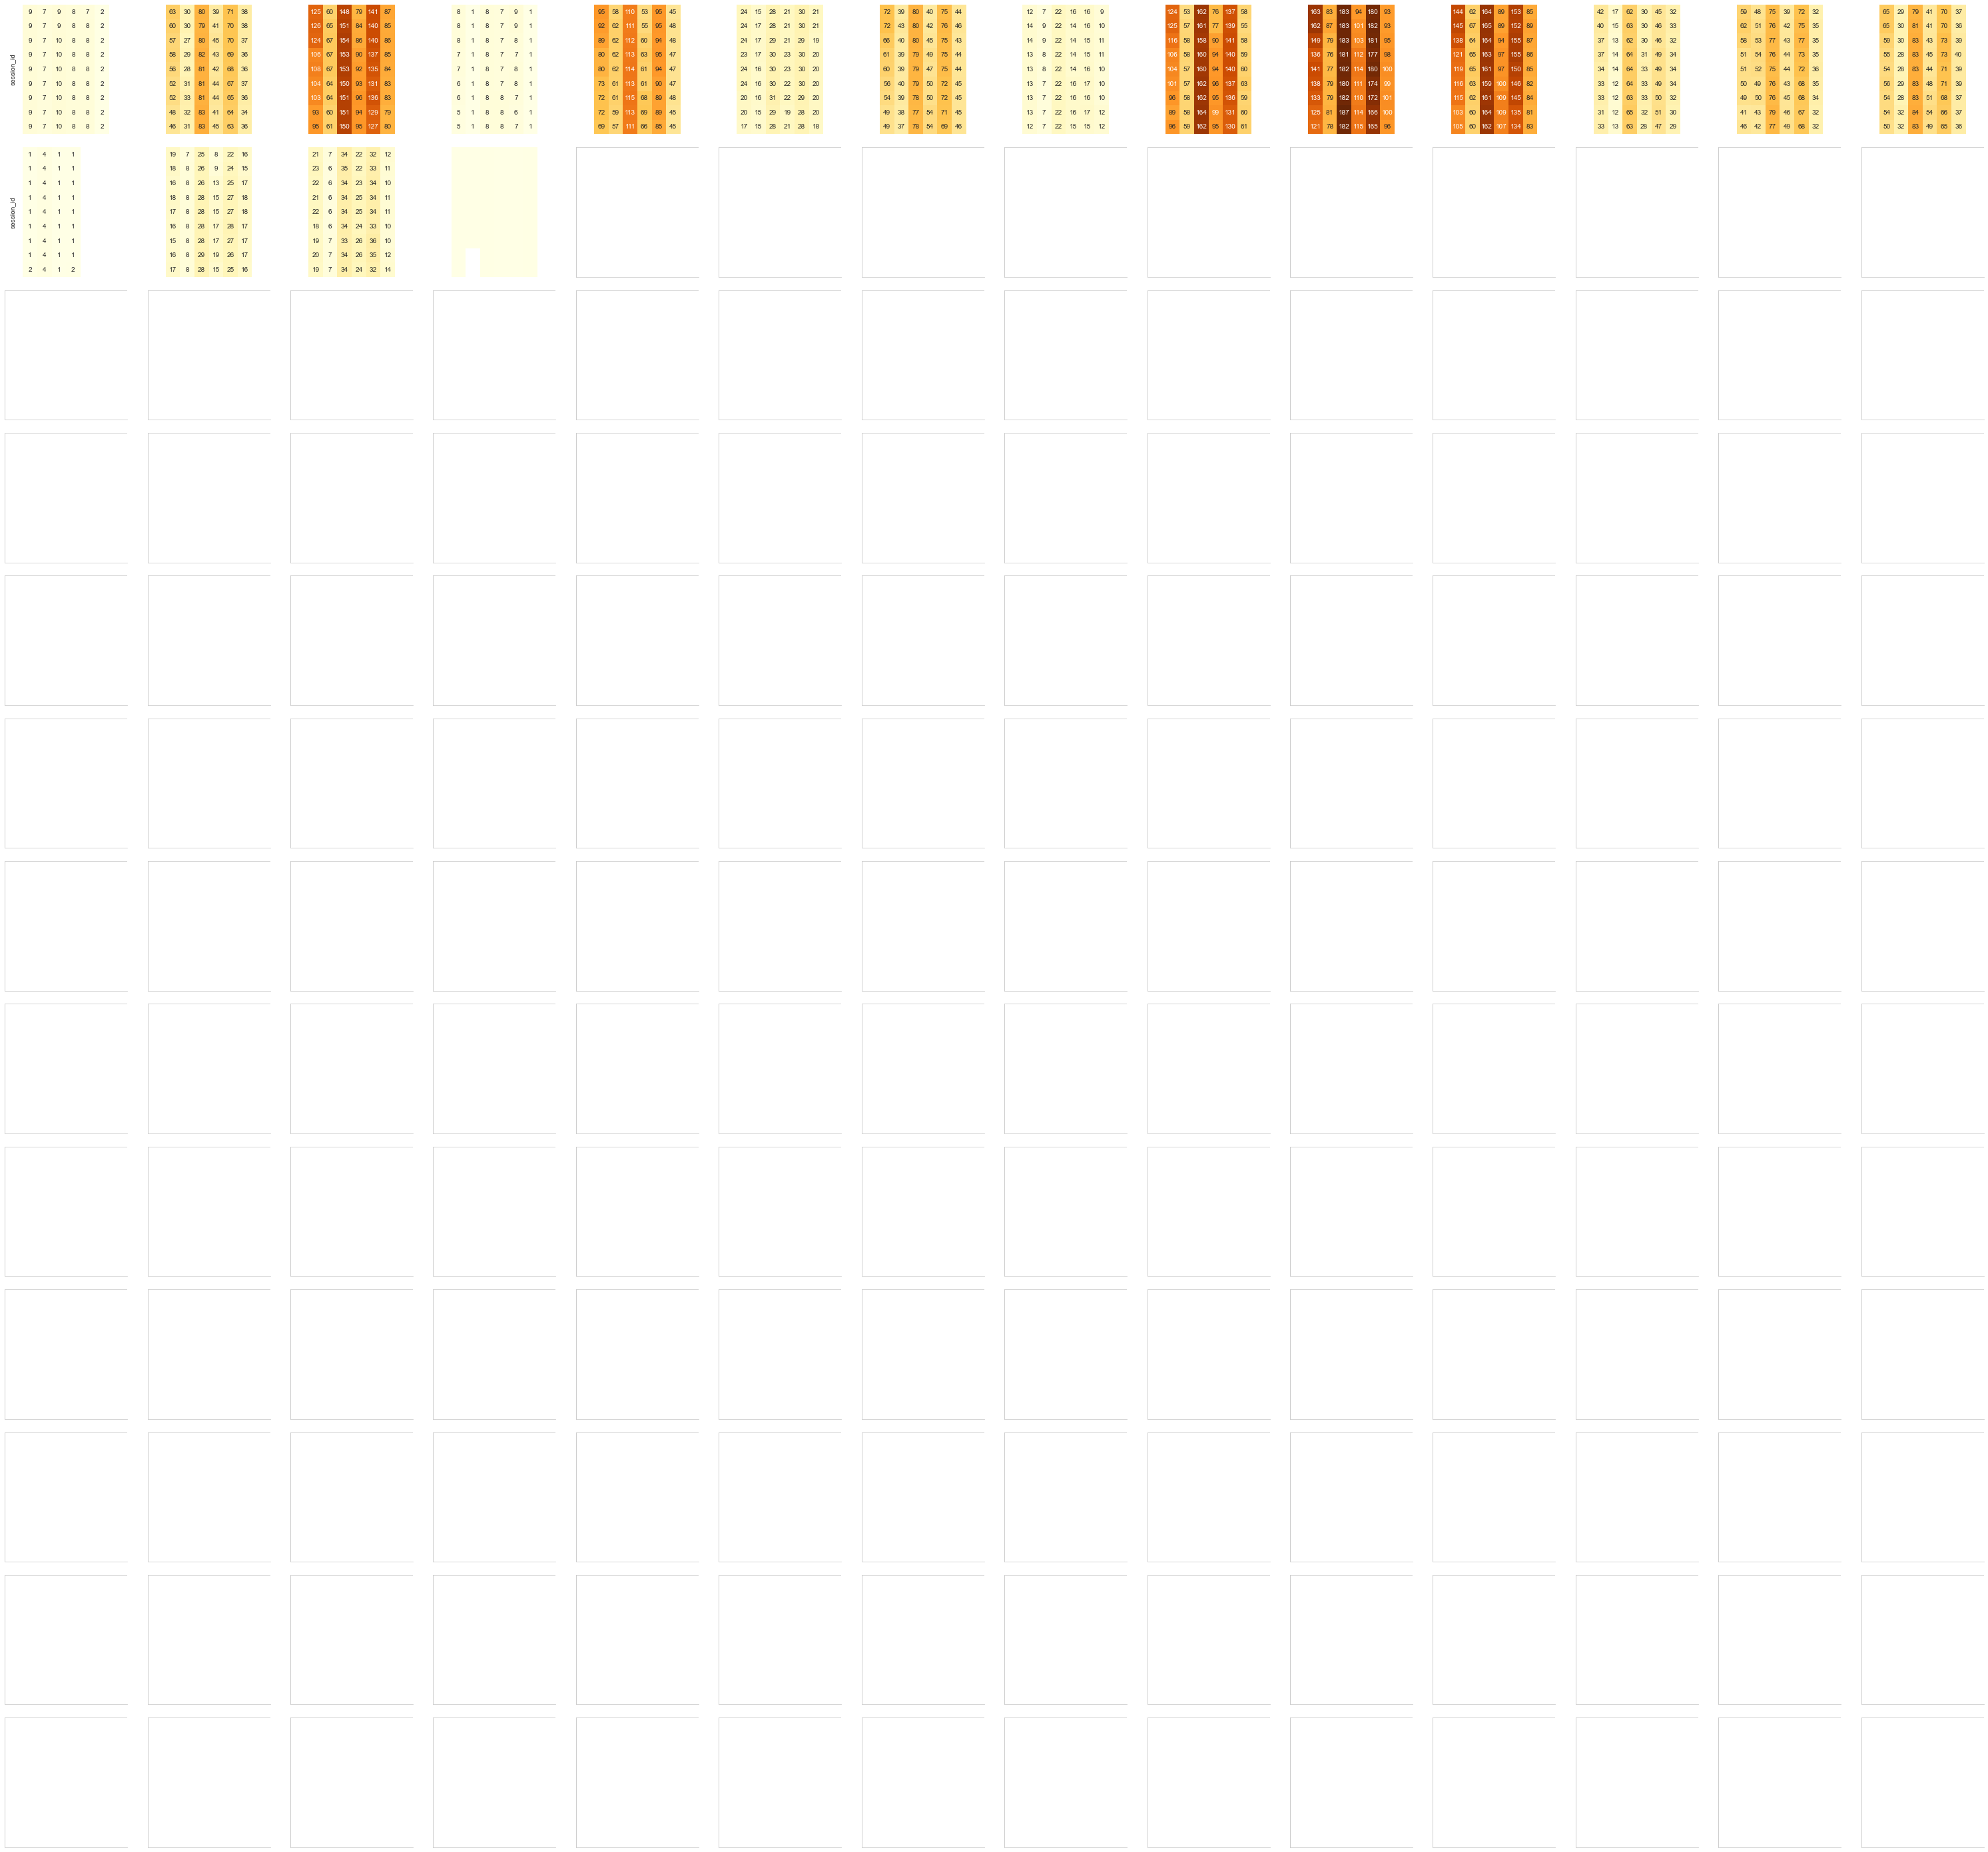

In [23]:
var_combinations2 = [['region','m_size'],['region','subject_matter_simpl'],
    ['m_size','subject_matter_simpl'],['m_size','governance_simpl'],
    ['governance','subject_matter_simpl'],
    ['m_size','governance'],['region','governance'],
    ['accreditation','governance'],['accreditation','m_size']]
#var_combinations2 = [['region','governance']]

for attrs in var_combinations2:
    df = mus_indic_attrib_df.copy()
    df = df.rename(columns={'size':'m_size'})
    attrs = attrs.copy()
    for a in attrs:
        df[a] = df[a].str.strip()
    attrs.insert(0, 'indicator_code_merged')
    attrs.insert(1, 'session_id')
    print(attrs)

    # create subfolder
    fold_var = fold + attrs[2] + '-' + attrs[3]
    for x in [fold_var]:        
        if not os.path.exists(x):
            os.makedirs(x)
    # pivot
    piv2_df = df.groupby(attrs, as_index=False).size()
    piv2_df = piv2_df.rename(columns={'size':'n_museums'})
    piv2_df['session_time'] = piv2_df['session_id'].apply(sessionid_to_time)
    # add total n of museums in each category
    mus_df = mdf.copy().rename(columns={'size':'m_size'})
    mus_df['region'] = mus_df.region.str.strip()
    counts_mdf = mus_df.groupby([attrs[2],attrs[3]],as_index=False).size()
    counts_mdf = counts_mdf.copy().rename(columns={'size':'n_museum_attrs_tot'})
    counts_mdf.to_excel(fold_var+'/museum_counts.xlsx',index=False)
    for a in attrs[2:3]:
        mus_df[a] = mus_df[a].str.strip()
    piv2_df = piv2_df.merge(counts_mdf, on=[attrs[2],attrs[3]], how='left')
    piv2_df['museum_indic_pc'] = round(piv2_df['n_museums'] / piv2_df['n_museum_attrs_tot'] * 100,1)
    #print(piv2_df.head())
    #print('testino',piv2_df[(piv2_df['region']=='East Midlands') & (piv2_df['m_size']=='large')]) # DEBUG
    #continue
    
    ex_fn = fold_var+'/indicators_'+attrs[2] + '-' + attrs[3]+'_counts.xlsx'
    print(ex_fn)
    piv2_df.to_excel(ex_fn, index=False)
    # plot
    for y_var in ['n_museums','museum_indic_pc']:
        plot_indic_small_mult_2vars(piv2_df, attrs, y_var, mdf, fold_var)
    os.system('say next')
    del piv2_df, attrs
                     
os.system('say done')

## Website size analysis

Analyse numer of pages and sizes and deltas of museum websites.

### Download data from DB

In [322]:
sql = "select * from analytics.website_sizes;"
websz_df = pd.read_sql(sql, db_conn)
websz_df = websz_df.drop(columns='index')
print(len(websz_df))
display(websz_df.sample(5))

for c in ['page_text_words', 'html_page_content_length', 'sum_links_words','links_level1']:
    websz_df[c] = df[c].fillna(0)

print("Museums N:",websz_df.museum_id.nunique())
print("Sessions N:",websz_df.session_id.nunique())

sz_fold = out_folder + 'data/analysis/website_sizes/'
print(sz_fold)
if not os.path.exists(sz_fold): os.makedirs(sz_fold)
websz_df.to_excel(sz_fold+'website_sizes.xlsx', index=False)

85


,url,session_id,links_level1,html_page_content_length,museum_id,museum_name,session_time,page_id,page_text_words,page_text_len,sum_links_length,sum_links_words
11,https://www.shetlandheritageassociation.com/me...,20210901,0,0.0,mm.New.97,George Waterston Memorial Museum,2021-09-01,NaN,0,0,NaN,NaN
24,https://www.visitouterhebrides.co.uk/see-and-d...,20210629,19,186737.0,mm.New.98,Ravenspoint Museum,2021-06-29,187296.0,1159,7562,150087.0,23192.0
16,https://www.shetlandheritageassociation.com/me...,20211108,0,0.0,mm.New.97,George Waterston Memorial Museum,2021-11-08,NaN,0,0,NaN,NaN
7,https://www.shetlandheritageassociation.com/me...,20210629,0,0.0,mm.New.97,George Waterston Memorial Museum,2021-06-29,NaN,0,0,NaN,NaN
13,https://www.shetlandheritageassociation.com/me...,20210927,0,0.0,mm.New.97,George Waterston Memorial Museum,2021-09-27,NaN,0,0,NaN,NaN


Museums N: 5
Sessions N: 17
../../data/analysis/website_sizes/


### Viz sizes

Text(0, 0.5, 'N museums')

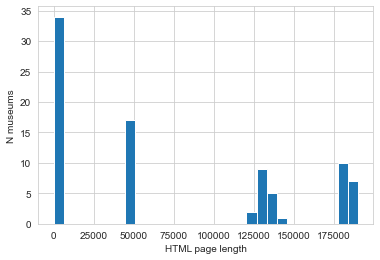

In [323]:
websz_df.html_page_content_length.hist(bins=30)
plt.xlabel('HTML page length')
plt.ylabel('N museums')

Text(0, 0.5, 'N museums')

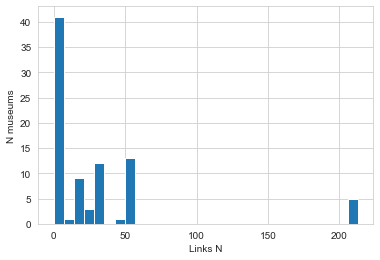

In [324]:
websz_df.links_level1.hist(bins=30)
plt.xlabel('Links N')
plt.ylabel('N museums')

In [325]:
for col in ['page_text_words', 'html_page_content_length', 'sum_links_words','links_level1']:
    g = sns.FacetGrid(websz_df, col='museum_name', col_wrap=4)
    g.map_dataframe(sns.lineplot, x="session_time", y=col) #, hue=group_var, style=group_var, marker='.')
    g.add_legend() #loc='lower right')
    #[ax.set(ylabel='') for ax in g.axes.flat]
    [plt.setp(ax.get_xticklabels(), rotation=45, ha='right') for ax in g.axes.flat]
    fn = '{}website_sizes-by_museum-{}.pdf'.format(sz_fold, col)
    plt.savefig(fn,bbox_inches='tight')
    plt.clf()
    print(fn)


../../data/analysis/website_sizes/website_sizes-by_museum-page_text_words.pdf
../../data/analysis/website_sizes/website_sizes-by_museum-html_page_content_length.pdf
../../data/analysis/website_sizes/website_sizes-by_museum-sum_links_words.pdf
../../data/analysis/website_sizes/website_sizes-by_museum-links_level1.pdf


<Figure size 872x432 with 0 Axes>

<Figure size 872x432 with 0 Axes>

<Figure size 872x432 with 0 Axes>

<Figure size 872x432 with 0 Axes>

In [326]:
# TODO: check zero cases

13/160*100

8.125

End of notebook.